In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Create the inspector and check table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Display column names and data types for Measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Display column names and data types for Station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.date(2017, 8, 23)
query_date = most_recent_date - dt.timedelta(days = 365)
print(query_date)

# Perform a query to retrieve the data and precipitation scores
last_year_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql(last_year_precip, session.bind)

precip_df.set_index('date', inplace = True)
precip_df.head(-1)

2016-08-23


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.00
2017-08-22,0.50
2017-08-23,0.00


In [14]:
# Drop null values
clean_precip_df = precip_df.dropna()
clean_precip_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


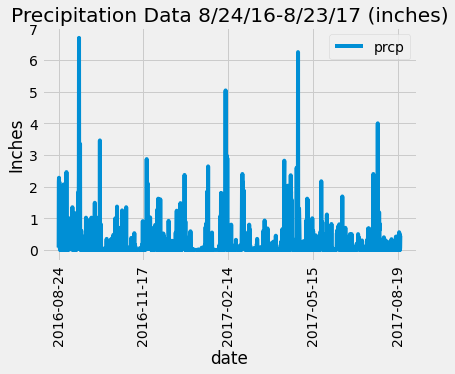

In [15]:
clean_precip_df.plot(y = 'prcp', rot = 90)
plt.title("Precipitation Data 8/24/16-8/23/17 (inches)")
plt.ylabel("Inches")
plt.show()

### Summary Statistics

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_count} unique stations in our dataset.")

There are 9 unique stations in our dataset.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
observation_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

for station in observation_counts:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stn = observation_counts[0][0]

most_active_summary = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_stn).\
    all()
min_temp = most_active_summary[0][0]
max_temp = most_active_summary[0][1]
avg_temp = most_active_summary[0][2]


print(f"The minimum temperature recorded at station {most_active_stn} is {min_temp} degrees F.")
print(f"The maximum temperature recorded at station {most_active_stn} is {max_temp} degrees F.")
print(f"The average temperature recorded at station {most_active_stn} is {avg_temp} degrees F.")

The minimum temperature recorded at station USC00519281 is 54.0 degrees F.
The maximum temperature recorded at station USC00519281 is 85.0 degrees F.
The average temperature recorded at station USC00519281 is 71.66378066378067 degrees F.


In [20]:
# Find most recent date for most active station
date = session.query(Measurement.date).\
    filter(Measurement.station == most_active_stn).\
    order_by(Measurement.date.desc()).\
    first()[0]
date

'2017-08-18'

In [21]:
# Create datetime object and use timedelta to get one year before
year = int(date[0:4])
month = int(date[5:7])
day = int(date[8:10])
temp_query_date = dt.date(year, month, day) - dt.timedelta(days = 365)
print(temp_query_date)

2016-08-18


In [22]:
# Query the last 12 months of temperature observation data for this station and create dataframe
last_year_temps = session.query(Measurement.tobs).\
    filter(Measurement.date > temp_query_date).\
    filter(Measurement.station == most_active_stn).statement
temps_df = pd.read_sql(last_year_temps, session.bind)
temps_df.head()

,tobs
0,79.0
1,81.0
2,79.0
3,78.0
4,77.0


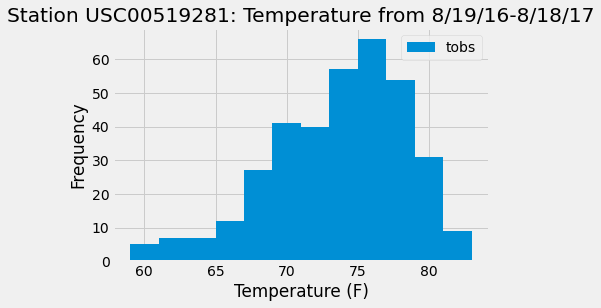

In [23]:
# Plot histogram
temps_df.plot(kind = 'hist', bins = 12)
plt.title(f"Station {most_active_stn}: Temperature from 8/19/16-8/18/17")
plt.xlabel("Temperature (F)")
plt.show()

## Hypothesis Testing

Running t-tests on average temperatures in June and December across all years in the dataset to test if there exists a meaningful difference between Hawaii's temperature during those two months. First, an independent t-test will be run on the raw data. Then, a paired t-test, will be run after accounting for the different number of observations in June and December by grouping the data by month-year and taking the mean so that the temperature data is paired by month and year.

$\mu$<sub>J</sub> = mean temperature in June across all weather stations and all years present in the dataset

$\mu$<sub>D</sub> = mean temperature in December across all weather stations and all years present in the dataset


H<sub>0</sub>: $\mu$<sub>J</sub> = $\mu$<sub>D</sub>

H<sub>a</sub>: $\mu$<sub>J</sub> $\neq$ $\mu$<sub>D</sub>


### Data Preparation

In [91]:
# Query data and create dataframe
all_temps = session.query(Measurement.date, Measurement.tobs).statement

all_temps_df = pd.read_sql(all_temps, session.bind)

# Convert date column to datetime and filter for June and December
all_temps_df.date = pd.to_datetime(all_temps_df.date)
june_dec_temps_df = all_temps_df[((all_temps_df.date.dt.month == 6) | (all_temps_df.date.dt.month == 12))]

# Set index to date
june_dec_temps_df.set_index("date", inplace=True)
june_dec_temps_df.head()

,tobs
date,
2010-06-01,78.0
2010-06-02,76.0
2010-06-03,78.0
2010-06-04,76.0
2010-06-05,77.0


### Independent t-test

In [110]:
# Store each month's data in variables and calculate mean temperatures
june_temps = june_dec_temps_df[june_dec_temps_df.index.month == 6].tobs
dec_temps = june_dec_temps_df[june_dec_temps_df.index.month == 12].tobs
june_avg = june_temps.mean()
dec_avg = dec_temps.mean()

print(june_temps)
print(dec_temps)
print("*"*50)
print(f"The mean temperature for June across all years is {june_avg} Fahrenheit")
print(f"The mean temperature for December across all years is {dec_avg} Fahrenheit")

date
2010-06-01    78.0
2010-06-02    76.0
2010-06-03    78.0
2010-06-04    76.0
2010-06-05    77.0
              ... 
2017-06-26    79.0
2017-06-27    74.0
2017-06-28    74.0
2017-06-29    76.0
2017-06-30    75.0
Name: tobs, Length: 1700, dtype: float64
date
2010-12-01    76.0
2010-12-03    74.0
2010-12-04    74.0
2010-12-06    64.0
2010-12-07    64.0
              ... 
2016-12-27    71.0
2016-12-28    71.0
2016-12-29    69.0
2016-12-30    65.0
2016-12-31    65.0
Name: tobs, Length: 1517, dtype: float64
**************************************************
The mean temperature for June across all years is 74.94411764705882 Fahrenheit
The mean temperature for December across all years is 71.04152933421226 Fahrenheit


In [107]:
# Run independent t-test assuming equal variance since all temperatures were taken in the same Hawaiian weather stations
stats.ttest_ind(june_temps, dec_temps, equal_var = True)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

With a pvalue=3.9025129038616655e-191, we may reject the null hypothesis. Our data suggests that there is a meaningful difference between Hawaii's mean temperature in June and December.

### Paired t-test

In [92]:
# Group and calculate mean by month/year 
mean_temps_df = test_df.groupby(pd.Grouper(freq="M")).mean().dropna(axis = 0)
mean_temps_df

,tobs,instance
date,,
2010-06-30,74.925620,1.0
2010-12-31,70.208511,1.0
2011-06-30,73.938326,1.0
2011-12-31,70.820628,1.0
2012-06-30,74.000000,1.0
2012-12-31,71.188073,1.0
2013-06-30,74.599078,1.0
2013-12-31,71.094017,1.0
2014-06-30,75.027907,1.0


In [97]:
# Check that the number of data points are equal for each month in order to run paired t-test
print(f"{mean_temps_df[mean_temps_df.index.month == 6].shape[0]} mean observations in June")
print(f"{mean_temps_df[mean_temps_df.index.month == 12].shape[0]} mean observations in December")

8 mean observations in June
7 mean observations in December


In [99]:
# For paired t-test, drop observation in June 2017 with no matching observation in December 2017 
mean_temps_df = mean_temps_df[~((mean_temps_df.index.month == 6) & (mean_temps_df.index.year == 2017))]
mean_temps_df

,tobs,instance
date,,
2010-06-30,74.925620,1.0
2010-12-31,70.208511,1.0
2011-06-30,73.938326,1.0
2011-12-31,70.820628,1.0
2012-06-30,74.000000,1.0
2012-12-31,71.188073,1.0
2013-06-30,74.599078,1.0
2013-12-31,71.094017,1.0
2014-06-30,75.027907,1.0


In [101]:
paired_june_temps = mean_temps_df[mean_temps_df.index.month == 6].tobs
paired_dec_temps = mean_temps_df[mean_temps_df.index.month == 12].tobs
print(f"{mean_temps_df[mean_temps_df.index.month == 6].shape[0]} mean observations in June")
print(f"{mean_temps_df[mean_temps_df.index.month == 12].shape[0]} mean observations in December")

date
2010-06-30    74.925620
2011-06-30    73.938326
2012-06-30    74.000000
2013-06-30    74.599078
2014-06-30    75.027907
2015-06-30    74.990148
2016-06-30    75.175258
Freq: 12M, Name: tobs, dtype: float64
date
2010-12-31    70.208511
2011-12-31    70.820628
2012-12-31    71.188073
2013-12-31    71.094017
2014-12-31    69.896861
2015-12-31    73.423913
2016-12-31    71.130000
Freq: 12M, Name: tobs, dtype: float64
7 mean observations in June
7 mean observations in December


In [103]:
# Perform indpendent t-test
stats.ttest_rel(paired_june_temps, paired_dec_temps)

Ttest_relResult(statistic=7.780060705002921, pvalue=0.00023742611093245777)

With a pvalue=0.00023742611093245777, we may reject the null hypothesis. Our data suggests that there is a meaningful difference between Hawaii's mean temperature in June and December.

# Close session

In [111]:
# Close Session
session.close()